In [1]:
%load_ext autoreload
%autoreload 2

import sys, warnings, glob, datetime
import xwmt, xwmb, xgcm, regionate, xbudget

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import CM4Xutils #needed to run pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import seaborn as sns
import cmocean.cm as cmo
import matplotlib.gridspec as gridspec
import pandas as pd


dpi = 100
mpl.rcParams['figure.dpi'] = dpi
sns.set_theme(context='notebook', style='ticks')

sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *

from SWMT_decomposition import *
from ant_plots import *
from isopycnal_plot_formatting import *
from select_max_loc import *

In [2]:
def cftime_to_decimal_year(times):
    """Convert xarray cftime to decimal years"""
    result = []
    for t in times:
        year = t.year
        start = type(t)(year, 1, 1, calendar=getattr(t, 'calendar', None))
        end = type(t)(year + 1, 1, 1, calendar=getattr(t, 'calendar', None))
        days_in_year = (end - start).days
        day_of_year = (t - start).days + (t - start).seconds / 86400.0
        result.append(year + day_of_year / days_in_year)
    return result

### Load in data

In [3]:
savedir = "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/"
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/" + x

In [4]:
ds = xr.open_dataset(
        datadir("/model/Southern_Ocean_50S_WMT_Budget.nc"))

ds["BF_Adv"] = ds["surface_ocean_flux_advective_negative_rhs"]
ds["BF_NonAdv"] = ds["boundary_fluxes"] - ds["BF_Adv"]

ds["surface_boundary_fluxes"] = ds["boundary_fluxes"] - ds["bottom_flux_heat"]

ds["boundary_fluxes_heat"] = ds["surface_ocean_flux_advective_negative_rhs_heat"] +\
                                 ds["surface_exchange_flux_heat"] +\
                                 ds["frazil_ice_heat"] + ds["bottom_flux_heat"]

ds["boundary_fluxes_salt"] = ds["surface_ocean_flux_advective_negative_rhs_salt"] +\
                                 ds["surface_exchange_flux_salt"]

ds["surface_boundary_fluxes_salt"] = 1 * ds["boundary_fluxes_salt"]
ds["surface_boundary_fluxes_heat"] = ds["boundary_fluxes_heat"] - ds["bottom_flux_heat"]

expt_colors = dict(); expt_colors["control"] = "#2f74b3"; expt_colors["forced"] = "#cc415a"

In [5]:
sigma = 36.974
toTg = 1e-9 

use_averaging = True 
ds_yearly = ds.groupby("time.year").mean("time")

psi40_abyssal = ds_yearly.sel(sigma2_l_target = slice(20, 37.1)).convergent_mass_transport
abyssal_dmdt = ds_yearly.sel(sigma2_l_target = slice(20, 37.1)).mass_tendency
abyssal_sbf = ds_yearly.sel(sigma2_l_target = slice(20, 37.1))["surface_boundary_fluxes"]
# ds_sigma = ds_yearly.sel(sigma2_l_target = sigma, method = "nearest")

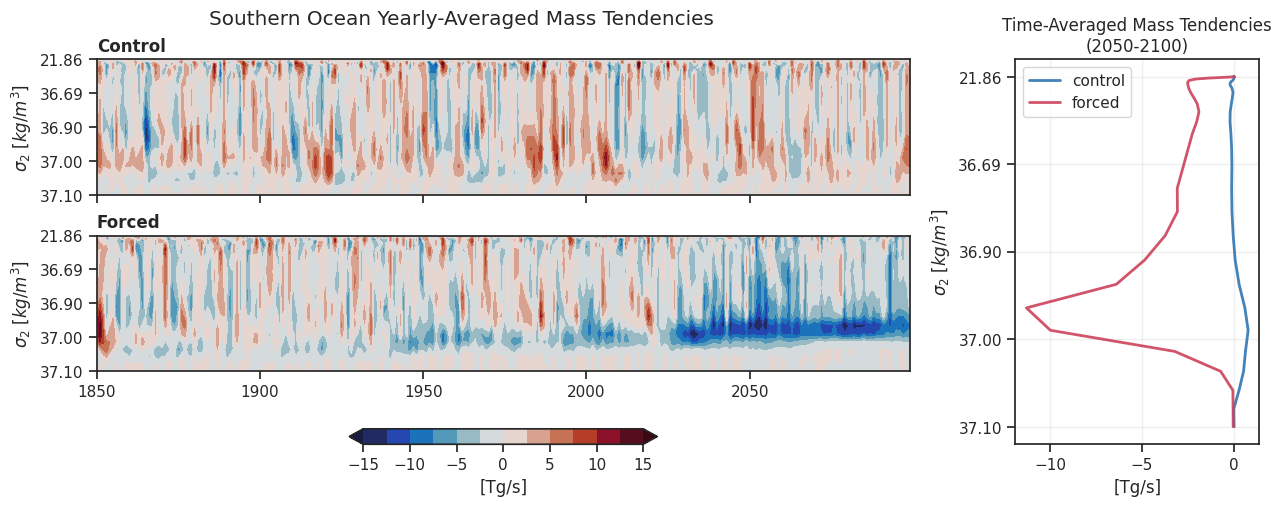

In [6]:
# Create a 2×2 GridSpec where the right column spans both rows
fig = plt.figure(figsize=(15, 5))
gs = fig.add_gridspec(2, 2, width_ratios=[1, 0.3], wspace=0.2, hspace=0.3)

# Left column: two stacked contour plots
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0], sharex=ax0)

# Right column: one plot spanning both rows
ax_side = fig.add_subplot(gs[:, 1])

ax = [ax0, ax1, ax_side]
year = psi40_abyssal.year
density =  psi40_abyssal.sigma2_l_target
telescope_power = 50
transformed_density = density_transform(density, telescope_power)

TIME, DENS = np.meshgrid(year, transformed_density)

levels = np.arange(-15, 15 + 0.1, 2.5)
ax[0].contourf(TIME,DENS, 
               toTg * abyssal_dmdt.sel(exp = "control").T, 
               levels = levels, extend = "both", cmap = cmo.balance)

cm = ax[1].contourf(TIME,DENS, 
               toTg * abyssal_dmdt.sel(exp = "forced").T, 
               levels = levels, extend = "both", cmap = cmo.balance)

fig.colorbar(cm, ax = ax[0:2], orientation = "horizontal", fraction = 0.04, label = "[Tg/s]")

fig.suptitle("Southern Ocean Yearly-Averaged Mass Tendencies ", x = 0.37)
ax[0].set_title("Control", loc='left', fontweight = "bold")
ax[1].set_title("Forced", loc='left', fontweight = "bold")
ax[0].tick_params(labelbottom=False)

formatter = create_density_formatter(density, transformed_density)

for a in ax: 
    a.tick_params(bottom=True, left=True)
    a.set_ylabel(r"$\sigma_2$" + " " + r"$[kg/m^3]$")
    a.yaxis.set_major_formatter(mticker.FuncFormatter(formatter))
    a.invert_yaxis()


abyssal_dmdt_mean = toTg * abyssal_dmdt.sel(year = slice(2050, 2100)).mean("year")
control_mean = abyssal_dmdt_mean.sel(exp = "control"); control_mean = control_mean.where(np.abs(control_mean) > 1e-8)
forced_mean = abyssal_dmdt_mean.sel(exp = "forced"); forced_mean = forced_mean.where(np.abs(forced_mean) > 1e-8)

ax[-1].plot(control_mean, transformed_density, c = expt_colors["control"], label = "control", alpha = .9, lw = 2)
ax[-1].plot(forced_mean, transformed_density, c = expt_colors["forced"], label = "forced", alpha = .9, lw = 2)
ax[-1].legend()
ax[-1].set_title("Time-Averaged Mass Tendencies\n(2050-2100)")
ax[-1].set_xlabel("[Tg/s]")
ax[-1].grid(alpha = 0.3)

xticks = ax1.get_yticks()
ax_side.set_yticks(xticks);

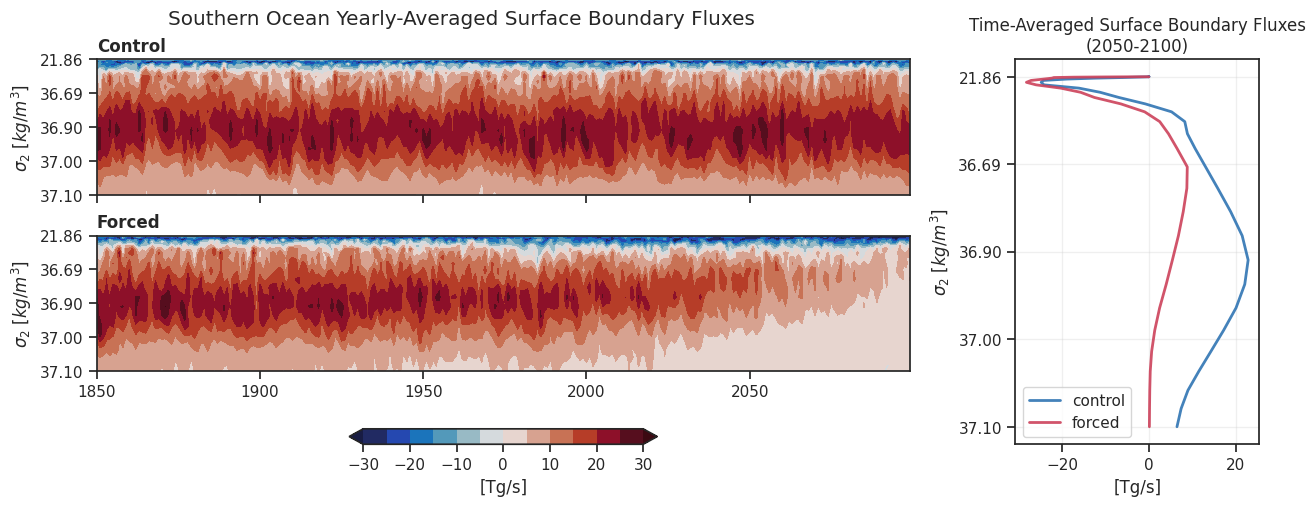

In [7]:
fig = plt.figure(figsize=(15, 5))
gs = fig.add_gridspec(2, 2, width_ratios=[1, 0.3], wspace=0.2, hspace=0.3)

# Left column: two stacked contour plots
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0], sharex=ax0)

# Right column: one plot spanning both rows
ax_side = fig.add_subplot(gs[:, 1])

ax = [ax0, ax1, ax_side]
ax[0].tick_params(labelbottom=False)

year = abyssal_sbf.year
density =  abyssal_sbf.sigma2_l_target
telescope_power = 50
transformed_density = density_transform(density, telescope_power)

TIME, DENS = np.meshgrid(year, transformed_density)

levels = np.arange(-30, 30 + 0.1, 5)
ax[0].contourf(TIME,DENS, 
               toTg * abyssal_sbf.sel(exp = "control").T, 
               levels = levels, extend = "both", cmap = cmo.balance)

cm = ax[1].contourf(TIME,DENS, 
               toTg * abyssal_sbf.sel(exp = "forced").T, 
               levels = levels, extend = "both", cmap = cmo.balance)

fig.colorbar(cm, ax = ax[0:2], orientation = "horizontal", fraction = 0.04, label = "[Tg/s]")

fig.suptitle("Southern Ocean Yearly-Averaged Surface Boundary Fluxes ", x = 0.37)
ax[0].set_title("Control", loc='left', fontweight = "bold")
ax[1].set_title("Forced", loc='left', fontweight = "bold")

formatter = create_density_formatter(density, transformed_density)

for a in ax: 
    a.tick_params(bottom=True, left=True)
    a.set_ylabel(r"$\sigma_2$" + " " + r"$[kg/m^3]$")
    a.yaxis.set_major_formatter(mticker.FuncFormatter(formatter))
    a.invert_yaxis()

abyssal_sbf_mean = abyssal_sbf.sel(year = slice(2050, 2100)).mean("year")
abyssal_sbf_mean = toTg *abyssal_sbf_mean
control_mean = abyssal_sbf_mean.sel(exp = "control"); control_mean = control_mean.where(np.abs(control_mean) > 1e-8)
forced_mean = abyssal_sbf_mean.sel(exp = "forced"); forced_mean = forced_mean.where(np.abs(forced_mean) > 1e-8)

ax[-1].plot(control_mean, transformed_density, c = expt_colors["control"], label = "control", alpha = .9, lw = 2)
ax[-1].plot(forced_mean, transformed_density, c = expt_colors["forced"], label = "forced", alpha = .9, lw = 2)
ax[-1].legend()
ax[-1].set_title("Time-Averaged Surface Boundary Fluxes\n(2050-2100)")
ax[-1].set_xlabel("[Tg/s]")
ax[-1].grid(alpha = 0.3)

xticks = ax1.get_yticks()
ax_side.set_yticks(xticks);

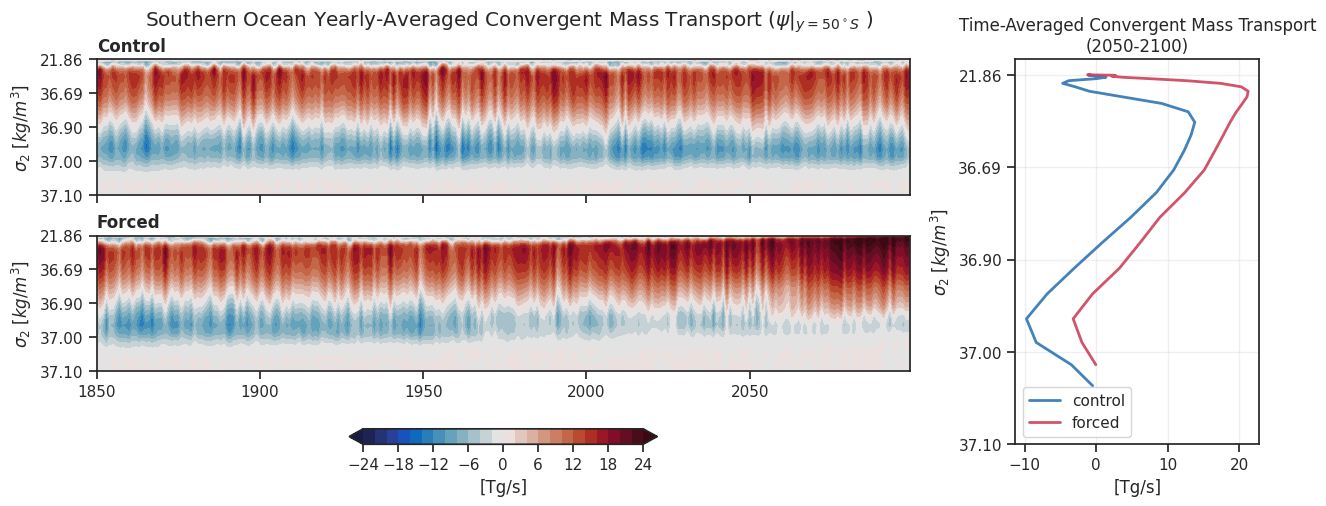

In [8]:
fig = plt.figure(figsize=(15, 5))
gs = fig.add_gridspec(2, 2, width_ratios=[1, 0.3], wspace=0.2, hspace=0.3)

# Left column: two stacked contour plots
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0], sharex=ax0)

# Right column: one plot spanning both rows
ax_side = fig.add_subplot(gs[:, 1])

ax = [ax0, ax1, ax_side]
ax[0].tick_params(labelbottom=False)

year = psi40_abyssal.year
density =  psi40_abyssal.sigma2_l_target
telescope_power = 50
transformed_density = density_transform(density, telescope_power)

TIME, DENS = np.meshgrid(year, transformed_density)

levels = np.arange(-24, 24 + 0.1, 2.0)
ax[0].contourf(TIME,DENS, 
               toTg * psi40_abyssal.sel(exp = "control").T, 
               levels = levels, extend = "both", cmap = cmo.balance)

cm = ax[1].contourf(TIME,DENS, 
               toTg * psi40_abyssal.sel(exp = "forced").T, 
               levels = levels, extend = "both", cmap = cmo.balance)

fig.colorbar(cm, ax = ax[0:2], orientation = "horizontal", fraction = 0.04, label = "[Tg/s]")

fig.suptitle("Southern Ocean Yearly-Averaged Convergent Mass Transport " + r"($\psi|_{y = 50^\circ S}$ )", x = 0.4)
ax[0].set_title("Control", loc='left', fontweight = "bold")
ax[1].set_title("Forced", loc='left', fontweight = "bold")

formatter = create_density_formatter(density, transformed_density)

for a in ax: 
    a.tick_params(bottom=True, left=True)
    a.set_ylabel(r"$\sigma_2$" + " " + r"$[kg/m^3]$")
    a.yaxis.set_major_formatter(mticker.FuncFormatter(formatter))
    a.invert_yaxis()

psi40_abyssal_mean = psi40_abyssal.sel(year = slice(2050, 2100)).mean("year")
psi40_abyssal_mean = toTg *psi40_abyssal_mean
control_mean = psi40_abyssal_mean.sel(exp = "control"); control_mean = control_mean.where(np.abs(control_mean) > 1e-8)
forced_mean = psi40_abyssal_mean.sel(exp = "forced"); forced_mean = forced_mean.where(np.abs(forced_mean) > 1e-8)

ax[-1].plot(control_mean, transformed_density, c = expt_colors["control"], label = "control", alpha = .9, lw = 2)
ax[-1].plot(forced_mean, transformed_density, c = expt_colors["forced"], label = "forced", alpha = .9, lw = 2)
ax[-1].legend()
ax[-1].set_title("Time-Averaged Convergent Mass Transport\n(2050-2100)")
ax[-1].set_xlabel("[Tg/s]")
ax[-1].grid(alpha = 0.3)

xticks = ax1.get_yticks()
ax_side.set_yticks(xticks);

## Calculating Maximum SBF

In [9]:
abyssal_sbf_crop = abyssal_sbf.sel(sigma2_l_target = slice(None, None))
abyssal_sbf_crop = abyssal_sbf_crop #.where(abyssal_sbf_crop > 0)
max_locations = abyssal_sbf_crop.argmax("sigma2_l_target")


control_max = abyssal_sbf_crop["sigma2_l_target"][max_locations.sel(exp = "control")].rename("max_surface_boundary_flux_density")
forced_max = abyssal_sbf_crop["sigma2_l_target"][max_locations.sel(exp = "forced")].rename("max_surface_boundary_flux_density")

max_sbf_loc = xr.concat([control_max, forced_max], dim = "exp")
max_sbf = select_from_location(abyssal_sbf_crop, max_sbf_loc)

Text(0.5, 1.0, 'SWMT at Corresponding Maximum\n($36.0\\ kg\\ m^{-3} < \\sigma_2$)')

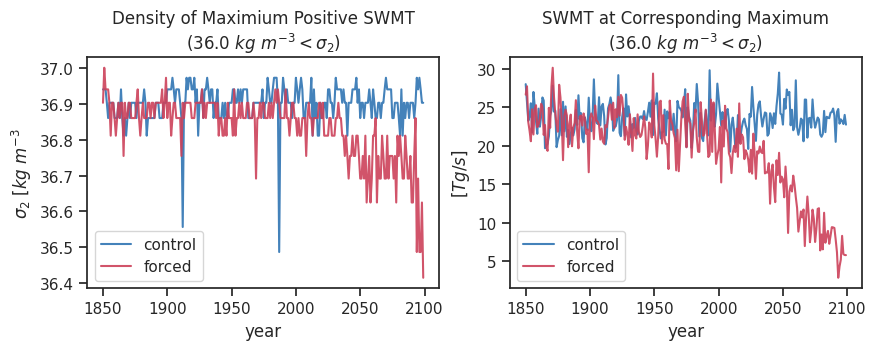

In [10]:
#PLOTTING 
year_rolling = 1
fig, ax = plt.subplots(1, 2, figsize = (10, 3))
max_sbf_loc_rolling = max_sbf_loc.rolling(year=year_rolling, center=True).mean().dropna("year")
expts = ["control", "forced"]
for expt in expts:
    max_sbf_loc_rolling.sel(exp =expt).plot(ax = ax[0], c = expt_colors[expt], label = expt, alpha = .9)
ax[0].legend()
ax[0].set_ylabel(r"$\sigma_2 \ [kg\ m^{-3}$")
ax[0].set_title("Density of Maximium Positive SWMT\n" + r"($36.0\ kg\ m^{-3} < \sigma_2$)")

max_sbf_rolling = toTg * max_sbf.rolling(year=year_rolling, center=True).mean().dropna("year")
for expt in expts:
    max_sbf_rolling.sel(exp =expt).plot(ax = ax[1], c = expt_colors[expt], label = expt, alpha = .9)
ax[1].legend()
ax[1].set_ylabel(r"$[Tg/s]$")

ax[1].set_title("SWMT at Corresponding Maximum\n" + r"($36.0\ kg\ m^{-3} < \sigma_2$)")

# fig.tight_layout()

## Calculating Maximum Overturning

In [11]:
abyssal_psi_crop = psi40_abyssal.sel(sigma2_l_target = slice(None, None))
max_psi_locations = abyssal_psi_crop.argmin("sigma2_l_target")

control_max = abyssal_psi_crop["sigma2_l_target"][max_psi_locations.sel(exp = "control")].rename("max_overturning_density")
forced_max = abyssal_psi_crop["sigma2_l_target"][max_psi_locations.sel(exp = "forced")].rename("max_overturning_density")

max_psi_loc = xr.concat([control_max, forced_max], dim = "exp")
max_psi = select_from_location(abyssal_psi_crop, max_psi_loc)

Text(0.5, 1.0, 'Minimum Overturning at Corresponding Minimum\n($36.0\\ kg\\ m^{-3} < \\sigma_2$)')

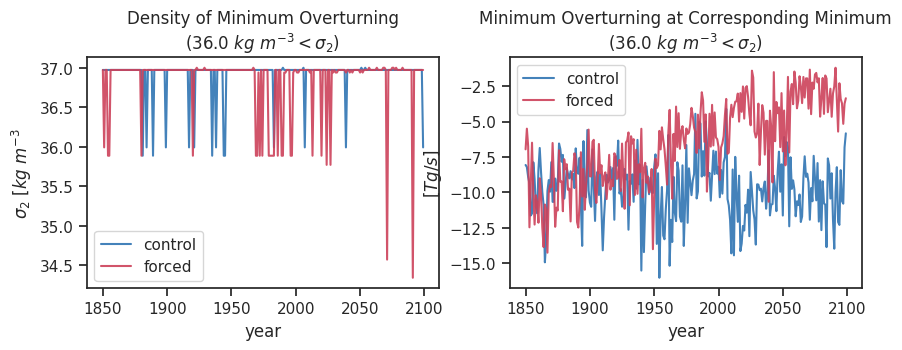

In [12]:
#PLOTTING 
year_rolling = 1
fig, ax = plt.subplots(1, 2, figsize = (10, 3))
max_sbf_loc_rolling = max_psi_loc.rolling(year=year_rolling, center=True).mean().dropna("year")
expts = ["control", "forced"]
for expt in expts:
    max_sbf_loc_rolling.sel(exp =expt).plot(ax = ax[0], c = expt_colors[expt], label = expt, alpha = .9)
ax[0].legend()
ax[0].set_ylabel(r"$\sigma_2 \ [kg\ m^{-3}$")
ax[0].set_title("Density of Minimum Overturning\n" + r"($36.0\ kg\ m^{-3} < \sigma_2$)")

max_sbf_rolling = toTg * max_psi.rolling(year=year_rolling, center=True).mean().dropna("year")
for expt in expts:
    max_sbf_rolling.sel(exp =expt).plot(ax = ax[1], c = expt_colors[expt], label = expt, alpha = .9)
ax[1].legend()
ax[1].set_ylabel(r"$[Tg/s]$")

ax[1].set_title("Minimum Overturning at Corresponding Minimum\n" + r"($36.0\ kg\ m^{-3} < \sigma_2$)")

# fig.tight_layout()

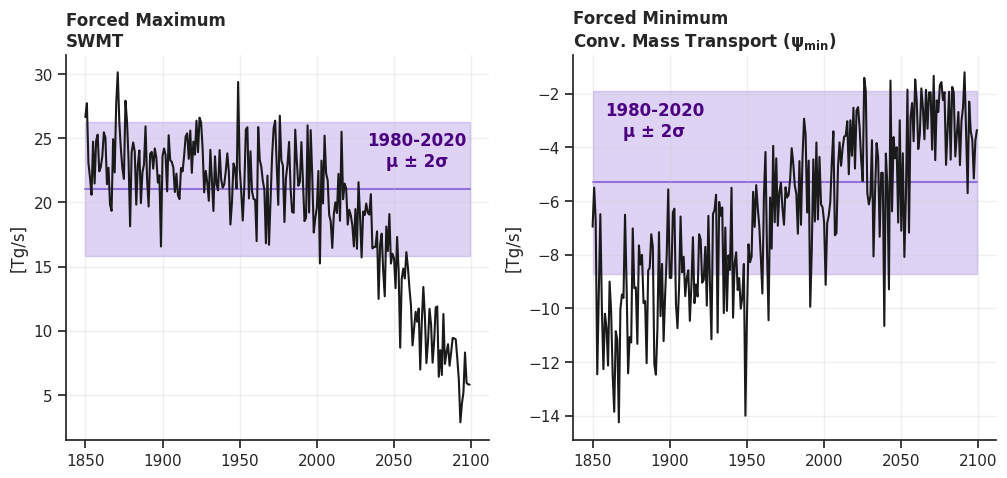

In [13]:
max_psi_forced = toTg * max_psi.sel(exp = "forced")
max_sbf_forced = toTg * max_sbf.sel(exp = "forced")

# max_sbf = select_from_location(abyssal_sbf_crop, max_psi_loc)
# max_sbf_forced = toTg * max_sbf.sel(exp = "forced")

# max_psi = select_from_location(abyssal_psi_crop, max_sbf_loc)
# max_psi_forced = toTg * max_psi.sel(exp = "forced")

def mean_and_std_over_time(data, dim = "time"):
    mean = data.mean(dim=dim, skipna=True)
    std = data.std(dim=dim, skipna=True)
    return mean.values, std.values

def plot_mean_std_over_time(ax, data, dim = "time", color = "black", label = None, time_slice=None, plot_kwargs = None): 
    plot_kwargs = plot_kwargs or {}

    if time_slice is not None:
        mean, std = mean_and_std_over_time(data.sel({dim: slice(*time_slice)}), dim=dim)
    else:
        mean, std = mean_and_std_over_time(data, dim = dim)

    time_values = data[dim].values[:]
    mean_arr = mean * np.ones_like(time_values)
    std_arr = std * np.ones_like(time_values)

    ax.plot(time_values, mean_arr, color = color, label = label, **plot_kwargs)
    ax.fill_between(time_values, mean_arr - 2 * std_arr, mean_arr + 2 * std_arr, color=color, alpha = 0.3, **plot_kwargs)


###### PLOTTING ########
baseline_times =  (1980, 2020)
baseline_color = "mediumpurple"
baseline_annot_color = "indigo"

forced_color = "k"

fig, ax = plt.subplots(1, 2, figsize = (12, 5), sharey = False, sharex = True)

plot_mean_std_over_time(ax[1], 
                        max_psi_forced, 
                        dim = "year", time_slice = baseline_times,
                        color = baseline_color,
                       plot_kwargs = {"zorder":0})

ax[1].plot(max_psi_forced.year, max_psi_forced, zorder = 100, color = forced_color)
ax[1].set_title("Forced Minimum\nConv. Mass Transport " + r"($\mathbf{\psi_{min}}$)", loc='left', fontweight = "bold")
ax[1].text(1890, -3, "-".join(map(str, baseline_times)) + "\nμ ± 2σ", 
           ha='center', va='center', 
           fontweight = "bold", color = baseline_annot_color)


plot_mean_std_over_time(ax[0], 
                        max_sbf_forced, 
                        color = baseline_color, dim = "year", time_slice = baseline_times,
                       plot_kwargs = {"zorder":0})
ax[0].plot(max_sbf_forced.year, max_sbf_forced, zorder = 100, color = forced_color)
ax[0].set_title("Forced Maximum\nSWMT", loc='left', fontweight = "bold")
ax[0].text(2065, 24, "-".join(map(str, baseline_times)) + "\nμ ± 2σ", 
           ha='center', va='center', 
           fontweight = "bold", color = baseline_annot_color)

for a in ax:
    a.set_ylabel("[Tg/s]")
    a.grid(alpha = 0.3)
    a.spines["top"].set_visible(False)
    a.spines["right"].set_visible(False)
    a.tick_params(bottom=True, left=True)

## Making a budget for a fixed density class

In [14]:
sigma_mean = max_sbf_loc.sel(exp = "control").mean("year")
sigma_nearest = ds.sigma2_l_target.sel(sigma2_l_target = sigma_mean, method = "nearest")

In [15]:
toTg = 1e-9 
mass_flux_units = "Tg/s"
mass_flux_units_conversion = toTg #kg to Tg 
sigma = np.round(sigma_nearest.values, decimals = 3)
# sigma = 36.974
tendencies = mass_flux_units_conversion * ds.sel(sigma2_l_target = sigma, method = "nearest").compute()
tendencies = tendencies.groupby("time.year").mean("time")
tendencies = tendencies.sel(year = slice("1850", None))

In [16]:
budgets = ['mass_tendency', 
           'surface_boundary_fluxes',
           # 'surface_ocean_flux_advective_negative_rhs_salt',
           'diffusion', 
           'spurious_numerical_mixing',
           'convergent_mass_transport', 
           # "bottom_flux_heat", #this term is basically zero 
           ]

budgets_labels = [r"$\partial_{t} \mathcal{M}_\geq$", 
                  # r"$\mathcal{G}^{SFC, \theta}_\geq$",
                  # r"$\mathcal{G}^{SFC, FW}_\geq$",
                  r"$\mathcal{G}^{SFC}_\geq$",
                  r"$\mathcal{G}^{mix}_\geq$",
                  r"$\mathcal{G}^{Spu}_\geq$",
                  r"$\Psi_\geq$", 
                  # r"$\mathcal{G}^{\theta_{BOT}}_\geq$", 
                  ]



0.10691740355344026
-3.9306846225767385


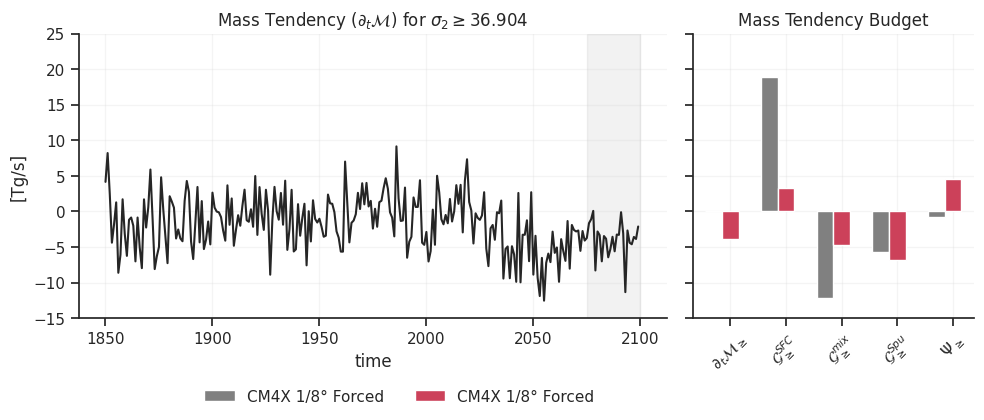

In [21]:
times = [("1980", "2020"), ("2075", "2100")]
focus_time = (2075, 2100)

# Create a figure
fig = plt.figure(figsize=(10, 4))

# Create a GridSpec with 4 columns, where the first plot takes up 3/4 and the second takes 1/4
gs = gridspec.GridSpec(1, 6)

###### PLOT 1. TIME SERIES ###########
ax1 = fig.add_subplot(gs[0, :4])
ax = ax1
ax.grid(alpha = 0.4, axis = "y")
width = 0.3

ax.grid(alpha = 0.2)

# ax.plot(tendencies.year, tendencies["mass_tendency"].sel(exp = "control"), 
#         label = "CM4Xp125\nforced", linewidth = 1.5, alpha = 0.95, c = expt_colors["control"])
ax.plot(tendencies.year, tendencies["mass_tendency"].sel(exp = "forced"), 
        label = "CM4Xp125\nforced", linewidth = 1.5, alpha = 0.95, c = "k")
ax.set_ylabel(f"[{mass_flux_units}]")

ax.set_title("Mass Tendency " + r"$(\partial_{t} \mathcal{M})$" + " for " + r"$\sigma_2 \geq$" +  f"{sigma}")
ax.set_xlabel("time")
ax.tick_params(bottom=True, left=True)

ax.axvspan(focus_time[0], focus_time[1], color='grey' , alpha=0.1, zorder = 0)

###### PLOT 2. BAR PLOT ###########
ax2 = fig.add_subplot(gs[0, 4:], sharey = ax1)
ax = ax2
exp = "forced"
curr_width = 0.0
times_colors = ["grey", expt_colors["forced"]]
for (it, t) in enumerate(times):
    wmt_mean = mass_flux_units_conversion * ds.sel(sigma2_l_target = sigma, method = "nearest")
    wmt_mean = wmt_mean.sel(time = slice(t[0], t[1])).mean("time")
    wmt_mean_budget =  wmt_mean.sel(exp = exp)
    print(wmt_mean_budget['mass_tendency'].values)
    bvalues = [wmt_mean_budget[k].values for k in budgets]

    nterms = np.arange(len(budgets_labels))

    ax.bar(nterms + curr_width, bvalues, label = "CM4X 1/8° " + exp.capitalize(), 
              width = width, color = times_colors[it])
    curr_width += width
    
ax.grid(alpha = 0.2)
ax.set_xticks(np.arange(len(budgets_labels)) + width, budgets_labels, rotation = 45)
ax.set_title("Mass Tendency Budget")
# ax.set_ylabel(f"[{mass_flux_units}]")
fig.tight_layout()
ax.legend(ncols = 2, bbox_to_anchor = (-0.3, -0.2), frameon = False)
ax.tick_params(bottom=True, left=True, labelleft=False)
fig.subplots_adjust(wspace = 0.2)
[a.set_ylim(-15, 25) for a in [ax1, ax2]]
# fig.savefig(plotsdir(f"paper_figures/dMdt_sigma_{sigma}.png"), bbox_inches = "tight", dpi = dpi)

for a in [ax1, ax2]:
    a.spines["top"].set_visible(False)
    a.spines["right"].set_visible(False)

In [34]:
var_to_label = {
    # heat budget
    "SWMT":             "net surface transformation",

    "SWMT_heat":             "heat",
    "SWMT_heat_latent":      "latent",
    "SWMT_heat_frazil":      "frazil",
    "SWMT_heat_longwave":    "longwave",
    "SWMT_heat_shortwave":   "shortwave",
    "SWMT_heat_mass_transfer":"mass_transfer",
    "SWMT_heat_sensible":    "sensible",
    "SWMT_salt_residual":    "salt residual",

    # salt budget
    "SWMT_salt":             "salt",
    "SWMT_salt_evaporation": "evap/precip",
    "SWMT_precipitation":    "evap/precip",
    "SWMT_salt_rivers":      "rivers",
    "SWMT_salt_icebergs":    "icebergs",
    "SWMT_salt_basal_salt":  "basal salt",
    "SWMT_salt_sea_ice":     "sea ice",
    "SWMT_heat_residual":    "heat residual",

}

In [1]:
tendencies_SWMT

NameError: name 'tendencies_SWMT' is not defined

In [35]:
tendencies_SWMT =  get_SWMT(tendencies)

exclude_vars = {"boundary_fluxes_heat", "SWMT", "SWMT_salt_approx", "SWMT_heat_approx", "SWMT_heat", "SWMT_salt"}
SWMT_decomp_vars = set(tendencies_SWMT.data_vars) - exclude_vars


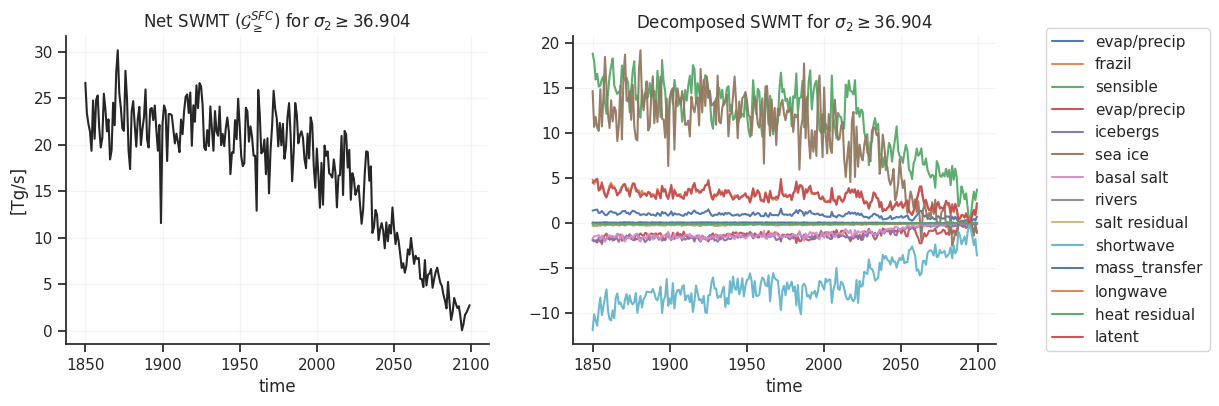

In [55]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

ax = axes[0]

ax.plot(tendencies_SWMT.year, tendencies_SWMT["SWMT"].sel(exp = "forced"), 
        label = "CM4Xp125\nforced", linewidth = 1.5, alpha = 0.95, c = "k")
ax.set_ylabel(f"[{mass_flux_units}]")

ax.set_title("Net SWMT " + r"($\mathcal{G}^{SFC}_\geq$)" + " for " + r"$\sigma_2 \geq$" +  f"{sigma}")
ax.set_xlabel("time")

ax = axes[1]
ax.set_title("Decomposed SWMT for " + r"$\sigma_2 \geq$" +  f"{sigma}")
ax.set_xlabel("time")
for var in SWMT_decomp_vars: 
    ax.plot(tendencies_SWMT.year, tendencies_SWMT[var].sel(exp = "forced"), 
        label = var_to_label[var], linewidth = 1.5, alpha = 0.95)
ax.legend(bbox_to_anchor = (1.1, 1.05))
for a in axes: 
    a.grid(alpha = 0.2)
    a.spines["top"].set_visible(False)
    a.spines["right"].set_visible(False)